In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import Counter
import numpy as np
from scipy import stats
from utils import (
    get_chord_diagram,
    get_normalized_norm,
    get_actual_survey_data_info,
    get_generated_survey_data_info,
    get_transient_prob_1_sim,
    get_transient_prob_2_sim,
    # get_transient_prob_3,
    # get_transient_prob_4,
    # get_transient_prob_5,
    # plot_table_inter_city_norm_2,
    # create_plots_for_destination_prob,
    plotting_the_dendogram,
    plotting_the_dendogram_JS

)
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
from scipy.spatial import distance
from scipy.stats import ttest_ind, levene
from sklearn.cluster import KMeans, AgglomerativeClustering
%load_ext autoreload
%autoreload 2

In [2]:
def get_transient_destination_probabilities(order=1):
    m_cities = {
        'SF_orig': eval(f't_orig_prob_{order}_sf'),
        'Gemini': eval(f't_prob_{order}_sf_gemini'),
        'Llama': eval(f't_prob_{order}_sf_llama'),
        'GPT-4': eval(f't_prob_{order}_sf_gpt4'),
        'Simulated': eval(f't_prob_{order}_sf_sim'),
    }

    res = {}
    for name, m in m_cities.items():
        vals = m.sum(0).to_dict()
        res[name] = vals
    res = pd.DataFrame(res)
    cols = [
        "Home",
        "Work",
        "Restaurant",
        "School",
        "Recreation",
        "Other",
    ]
    res.index = cols
    res = res / res.sum()
    return res

In [3]:
data_t_sf, ranks_original_sf, relative_freqs_original_sf = get_actual_survey_data_info(
    'dataset/NHTS_2017_csv/processed_data/sf',
    'Actual SF',
    new_loc_type=False,
    sim_loc_type=True
)

Actual SF
**************************************************
Average Location: 5.351378197169108
Average Location: 5.0
Number of samples: 4027
Travel time (Hrs): 1.7411927820544657
**************************************************


In [4]:
data_t_all, ranks_original_all, relative_freqs_original_all = get_actual_survey_data_info(
    'dataset/NHTS_2017_csv/processed_data/all',
    'Actual All',
    new_loc_type=False,
    sim_loc_type=True
)

Actual All
**************************************************
Average Location: 5.186141044006679
Average Location: 5.0
Number of samples: 219194
Travel time (Hrs): 1.5138712738487368
**************************************************


In [5]:
t_sf_gemini, ranks_sf_gemini, relative_freqs_sf_gemini = get_generated_survey_data_info(
    'outputs_processed/outputs_processed_completion_sf_gemini.csv',
    'Generated SF',
    new_loc_type=False,
    pre_process=False,
    sim_loc_type=True
)


Generated SF
**************************************************
Average Location: 6.599516518936341
Median Location: 6.0
Number of samples: 1241
Travel time: 2.5287474747474747
**************************************************


In [6]:
t_sf_llama, ranks_sf_llama, relative_freqs_sf_llama = get_generated_survey_data_info(
    'outputs_processed/outputs_processed_completion_sf_llama.csv',
    'Generated SF',
    new_loc_type=False,
    pre_process=True,
    sim_loc_type=True
)


Generated SF
**************************************************
Average Location: 5.559812353401095
Median Location: 5.0
Number of samples: 1279
Travel time: 7.179538180155465
**************************************************


In [7]:
t_sf_gpt4, ranks_sf_gpt4, relative_freqs_sf_gpt4 = get_generated_survey_data_info(
    'outputs_processed/outputs_processed_completion_sf_gpt4.csv',
    'Generated SF',
    new_loc_type=False,
    pre_process=False,
    sim_loc_type=True
)


Generated SF
**************************************************
Average Location: 6.963662790697675
Median Location: 7.0
Number of samples: 688
Travel time: 2.522167487684729
**************************************************


In [8]:
t_sf_llama_trained_large_exclude_infer_cities_3, ranks_sf_llama_trained_large_exclude_infer_cities_3, relative_freqs_sf_llama_trained_large_exclude_infer_cities_3 = get_generated_survey_data_info(
    'outputs_processed/outputs_processed_completion_sf_llama_trained_large_exclude_infer_cities_3.csv',
    'Generated SF',
    new_loc_type=False,
    pre_process=False,
    sim_loc_type=True
)

Generated SF
**************************************************
Average Location: 4.790940766550523
Median Location: 4.0
Number of samples: 1435
Travel time: 1.6094490934449093
**************************************************


In [9]:
t_sf_llama_trained_large_3, ranks_sf_llama_trained_large_3, relative_freqs_sf_llama_trained_large_3 = get_generated_survey_data_info(
    'outputs_processed/outputs_processed_completion_sf_llama_trained_large_3.csv',
    'Generated SF',
    new_loc_type=False,
    pre_process=False,
    sim_loc_type=True
)

Generated SF
**************************************************
Average Location: 4.975895316804408
Median Location: 4.0
Number of samples: 1452
Travel time: 1.5334481966459912
**************************************************


### Get Simulated Data

In [10]:
def get_single_day_values(x):
    time_values = x.tick
    location_values = x.building_type
    max_value = max(time_values)
    # Determine the number of sublists needed
    num_sublists = max_value // 288 + 1
    # Initialize the list of sublists
    grouped_lists = [[] for _ in range(num_sublists)]

    for value in time_values:
        sublist_index = value // 288
        grouped_lists[sublist_index].append(value)

    grouped_location_lists = [[] for _ in range(num_sublists)]

    # Group the location type values into sublists
    for i, value in enumerate(location_values):
        sublist_index = time_values[i] // 288  # Use the corresponding time value to determine the sublist index
        grouped_location_lists[sublist_index].append(value)

    for i, each in enumerate(grouped_location_lists):
        if i ==0:
            continue
        each.insert(0, 'H')

    rand_val = np.random.randint(0, len(grouped_lists))
    return grouped_location_lists[rand_val]

def convert_to_numeric_loc_types(x):
    loc_types = []
    for each in x:
        if each == 'H':
            loc_types.append(1)
        elif each == 'W':
            loc_types.append(2)
        elif each == 'Res':
            loc_types.append(3)
        elif each == 'Sch':
            loc_types.append(4)
        elif each == 'Rec':
            loc_types.append(5)
        else:
            loc_types.append(6)
    return loc_types

In [11]:
data = pd.read_csv(open('/Users/prb977/Project/travel_survey_llm/dataset/simulation.csv', "r", encoding="utf-8"))
a = data.groupby('agent_id')['tick'].apply(list)
b = data.groupby('agent_id')['building_type'].apply(list)
c = pd.concat([a,b], axis=1).reset_index()
c['loc_type_cat'] = c.apply(lambda x: get_single_day_values(x), axis=1)
c['loc_type'] = c['loc_type_cat'].apply(lambda x: convert_to_numeric_loc_types(x))

In [19]:
t_sf_sim = c.sample(1435, random_state=42)

In [20]:
print(np.mean(t_sf_sim['loc_type'].apply(lambda x: len(x))))
print(np.median(t_sf_sim['loc_type'].apply(lambda x: len(x))))

3.986759581881533
4.0


## Statistical Significance Test

In [24]:
data_t_sf_loc = data_t_sf['location'].to_list()

t_sf_gemini_loc = t_sf_gemini['loc_type_new'].apply(lambda x: len(x)).to_list()

t_sf_llama_loc = t_sf_llama['loc_type_new'].apply(lambda x: len(x)).to_list()

t_sf_gpt4_loc = t_sf_gpt4['loc_type_new'].apply(lambda x: len(x)).to_list()

t_sf_llama_trained_large_exclude_infer_cities_3_loc = t_sf_llama_trained_large_exclude_infer_cities_3['loc_type_new'].apply(lambda x: len(x)).to_list()
t_sf_llama_trained_large_3_loc = t_sf_llama_trained_large_3['loc_type_new'].apply(lambda x: len(x)).to_list()

t_sf_sim_loc = t_sf_sim['loc_type'].apply(lambda x: len(x)).to_list()

In [22]:
actual_color = 'tab:blue'
gemini_color = 'tab:orange'
llama_color = 'tab:green'
gpt4_color = 'tab:red'
ens_color = 'tab:purple'
sim_color = 'tab:brown'
one_color_line = 'tab:olive'
ten_color_line = 'tab:cyan'

In [23]:
def loc_significance_test(t_actual, t_others, name='SF'):

    fig, axes = plt.subplots(int(np.ceil(len(t_others)/2)),2, figsize=(20, int(np.ceil(len(t_others)/2))*3))
    all = t_actual .copy()
    for e in list(t_others.values()):
        all += e
    
    number_counts_actual = {num: 0 for num in range(1, max(all))}
    number_counts_actual.update(Counter(t_actual))

    for i, (key, value) in enumerate(t_others.items()):
        number_counts_temp = {num: 0 for num in range(1, max(all))}
        number_counts_temp.update(Counter(value))
        if len(t_others) == 2:
            ax = axes[i]
        else:
            ax = axes[i//2, i%2]
        ax.bar(
            list(number_counts_actual.keys()),
            list(number_counts_actual.values()),
            alpha=0.5,
            label=f'Actual',
            color=actual_color
        )
        ax.bar(
            list(number_counts_temp.keys()),
            list(number_counts_temp.values()),
            alpha=0.5,
            label=f'{key}',
            color=gemini_color
        )
        ax.set_xticks(list(number_counts_actual.keys()))
        ax.legend(loc='best')


    plt.tight_layout()
    plt.show()

    alpha = 0.05

    for i, (key, value) in enumerate(t_others.items()):
        print('\n'+key)
        stat, p_value = levene(t_actual, value)
        # Print the results
        print(f"Levene's test statistic: {stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        if p_value > alpha:
            print('Equal variances')
        else:
            print('Unequal variances')

        t_stat, p_value = ttest_ind(t_actual, value, equal_var=False)
        # Print the results
        print(f"Welch's t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.3f}")

        if p_value > alpha:
            print('Same distribution')
        else:
            print('Different distribution')


def loc_significance_test_percentage(t_actual, t_others, name='SF'):

    fig, axes = plt.subplots(int(np.ceil(len(t_others)/2)),2, figsize=(10, int(np.ceil(len(t_others)/2))*2))
    all = t_actual .copy()
    for e in list(t_others.values()):
        all += e
    
    number_counts_actual = {num: 0 for num in range(1, max(all))}
    number_counts_actual.update(Counter(t_actual))
    total_count = len(t_actual)
    number_percentages_actual = {num: (count / total_count) * 100 for num, count in number_counts_actual.items()}


    for i, (key, value) in enumerate(t_others.items()):
        number_counts_temp = {num: 0 for num in range(1, max(all))}
        number_counts_temp.update(Counter(value))
        total_count = len(value)
        number_percentages_temp = {num: (count / total_count) * 100 for num, count in number_counts_temp.items()}
        if len(t_others) == 2:
            ax = axes[i]
        else:
            ax = axes[i//2, i%2]
        ax.bar(
            list(number_percentages_actual.keys()),
            list(number_percentages_actual.values()),
            alpha=0.5,
            label=f'Actual',
            color=actual_color
        )
        ax.bar(
            list(number_percentages_temp.keys()),
            list(number_percentages_temp.values()),
            alpha=0.5,
            label=f'{key}',
            color=gemini_color
        )
        ax.set_xticks(list(number_percentages_actual.keys()))
        ax.legend(loc='best')


    plt.tight_layout()
    plt.show()

    alpha = 0.05

    for i, (key, value) in enumerate(t_others.items()):
        print('\n'+key)
        stat, p_value = levene(t_actual, value)
        # Print the results
        print(f"Levene's test statistic: {stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        if p_value > alpha:
            print('Equal variances')
        else:
            print('Unequal variances')

        t_stat, p_value = ttest_ind(t_actual, value, equal_var=False)
        # Print the results
        print(f"Welch's t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.3f}")

        if p_value > alpha:
            print('Same distribution')
        else:
            print('Different distribution')


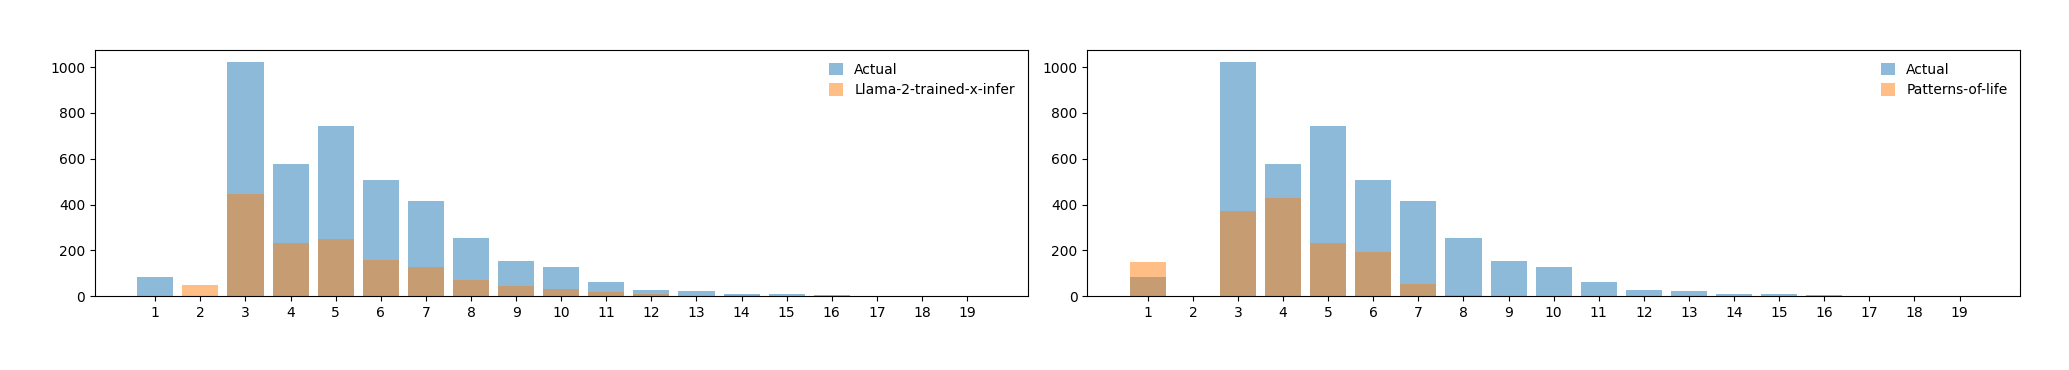


Llama-2-trained-x-infer
Levene's test statistic: 3.904
p-value: 0.048
Unequal variances
Welch's t-statistic: 5.384
p-value: 0.000
Different distribution

Patterns-of-life
Levene's test statistic: 224.666
p-value: 0.000
Unequal variances
Welch's t-statistic: 24.600
p-value: 0.000
Different distribution


In [25]:
others = {
    # 'Gemini': t_sf_gemini_loc,
    # 'Llama': t_sf_llama_loc,
    # 'GPT-4': t_sf_gpt4_loc,
    # 'Llama-2-trained-x-infer': t_sf_llama_trained_large_exclude_infer_cities_3_loc,
    'Llama-2-trained-x-infer': t_sf_llama_trained_large_3_loc,
    'Patterns-of-life': t_sf_sim_loc
}
loc_significance_test(data_t_sf_loc, others, 'SF')

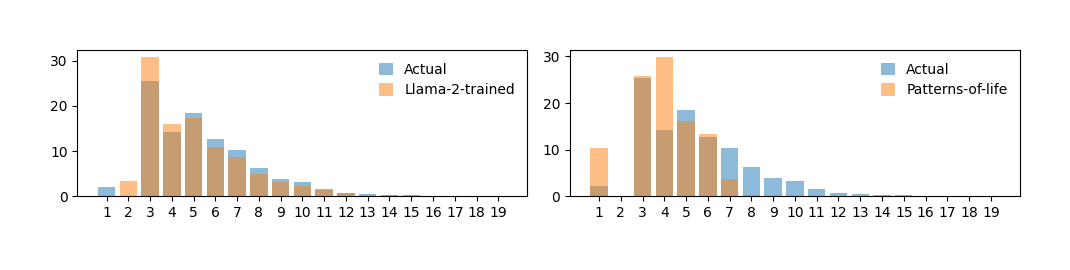


Llama-2-trained
Levene's test statistic: 3.904
p-value: 0.048
Unequal variances
Welch's t-statistic: 5.384
p-value: 0.000
Different distribution

Patterns-of-life
Levene's test statistic: 224.666
p-value: 0.000
Unequal variances
Welch's t-statistic: 24.600
p-value: 0.000
Different distribution


In [29]:
others = {
    # 'Gemini': t_sf_gemini_loc,
    # 'Llama': t_sf_llama_loc,
    # 'GPT-4': t_sf_gpt4_loc,
    # 'Llama-2-trained-x-infer': t_sf_llama_trained_large_exclude_infer_cities_3_loc,
    'Llama-2-trained': t_sf_llama_trained_large_3_loc,
    'Patterns-of-life': t_sf_sim_loc
}
loc_significance_test_percentage(data_t_sf_loc, others, 'SF')

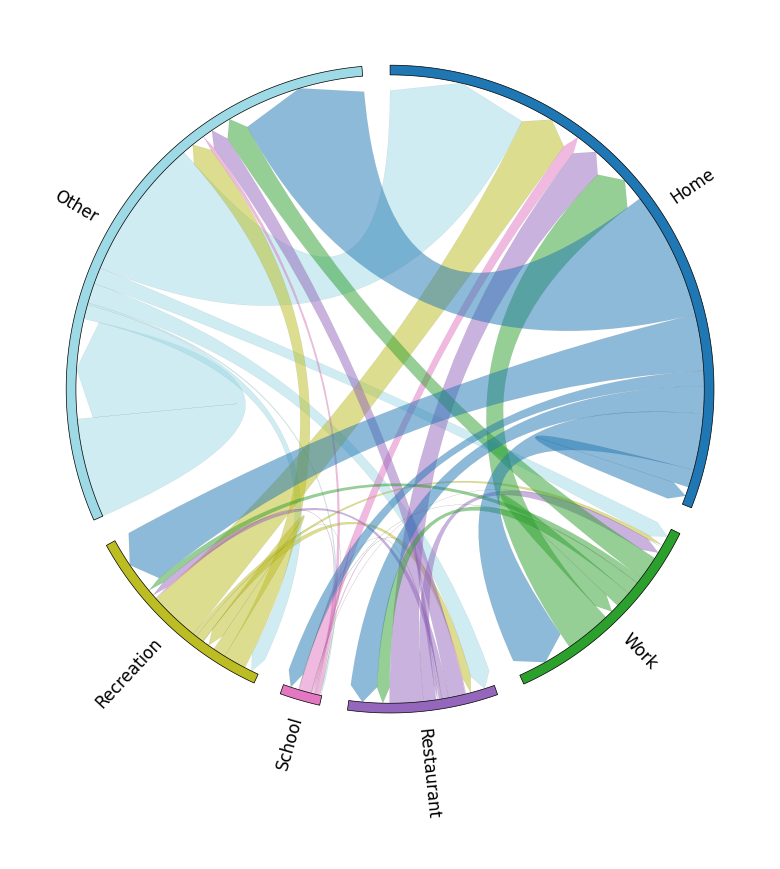

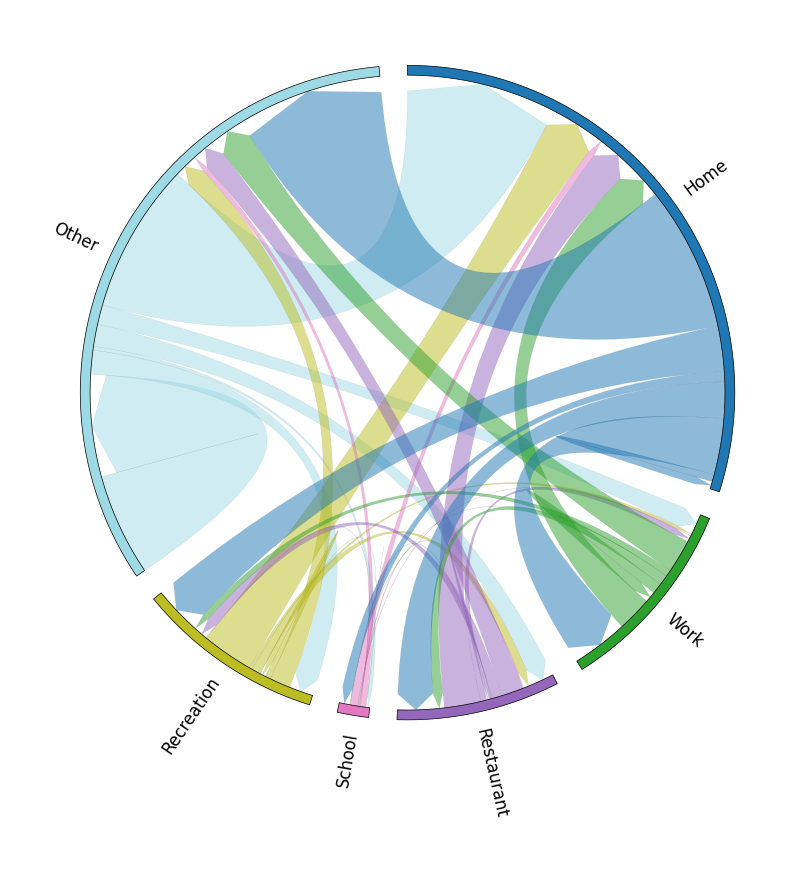

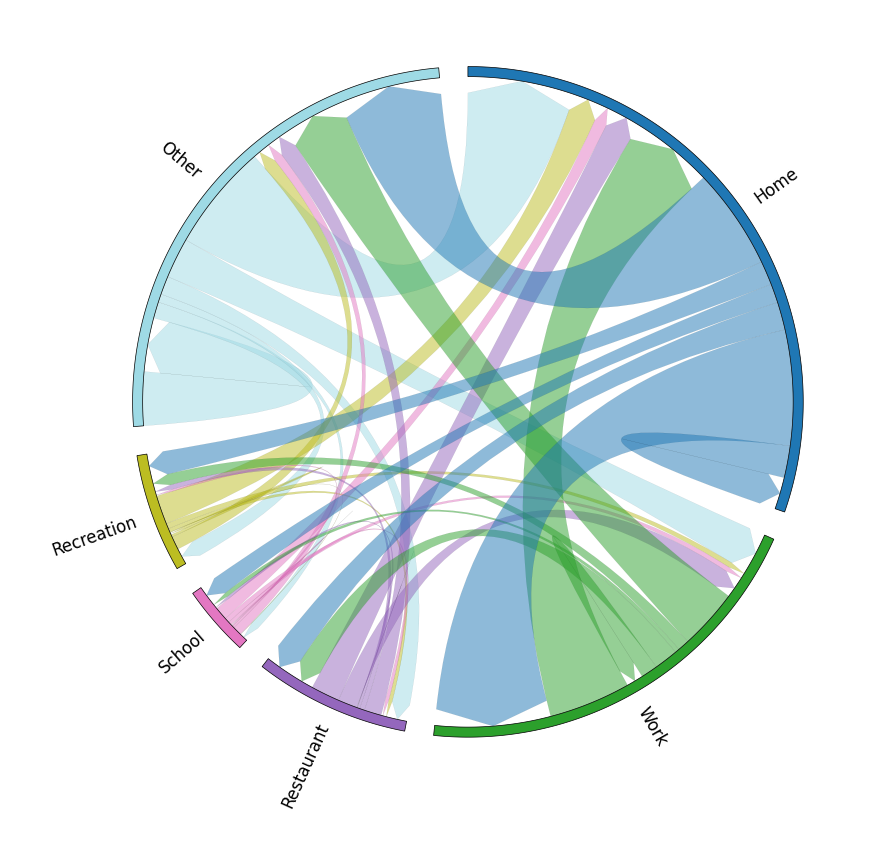

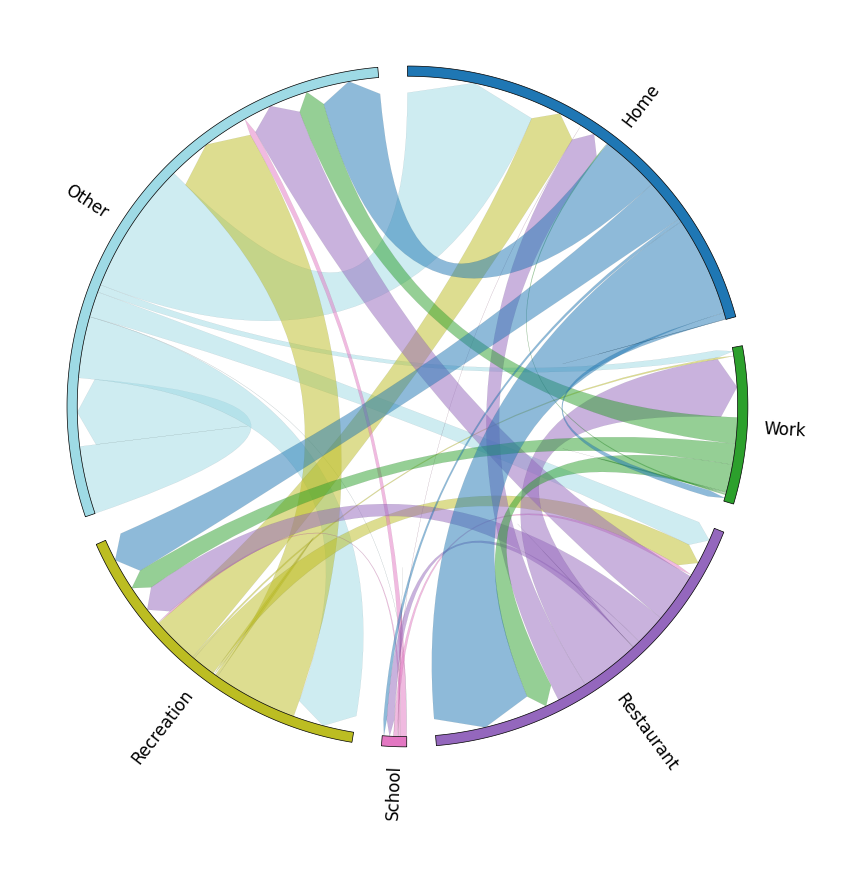

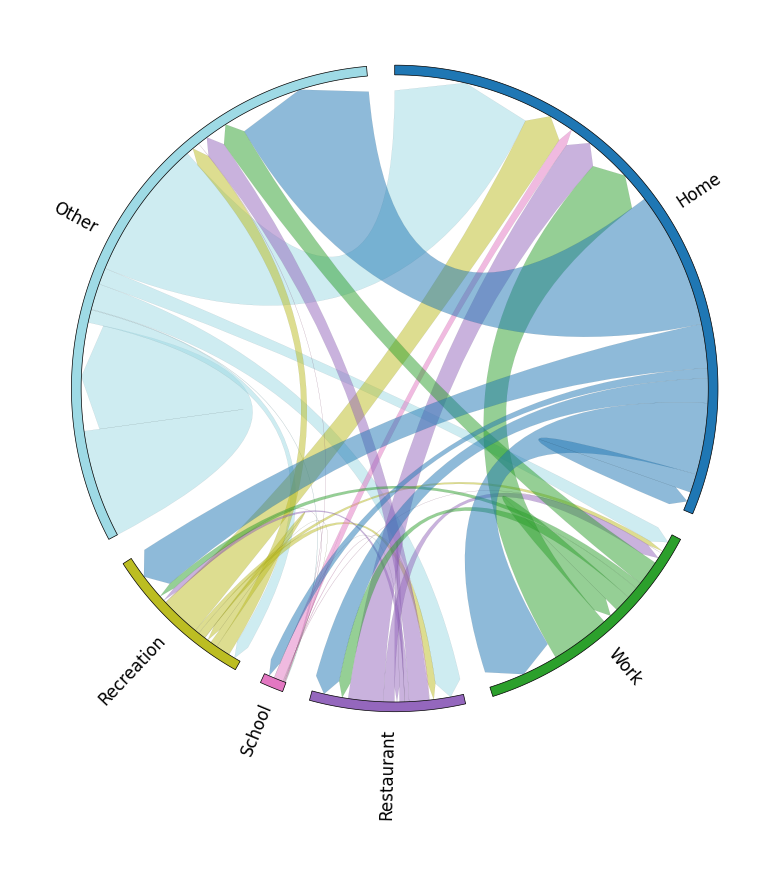

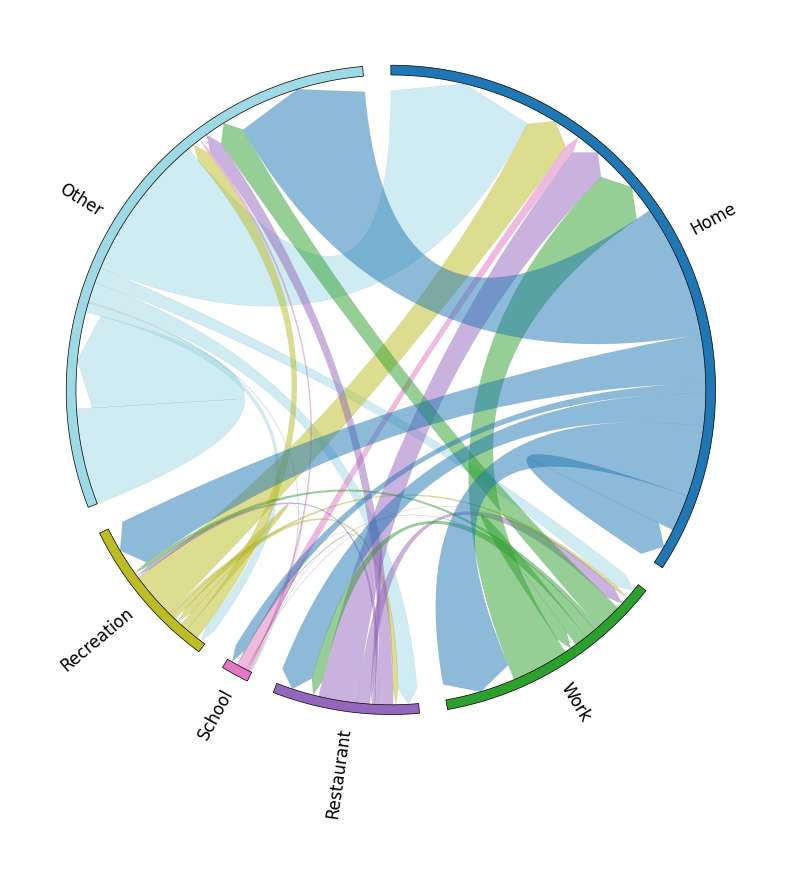

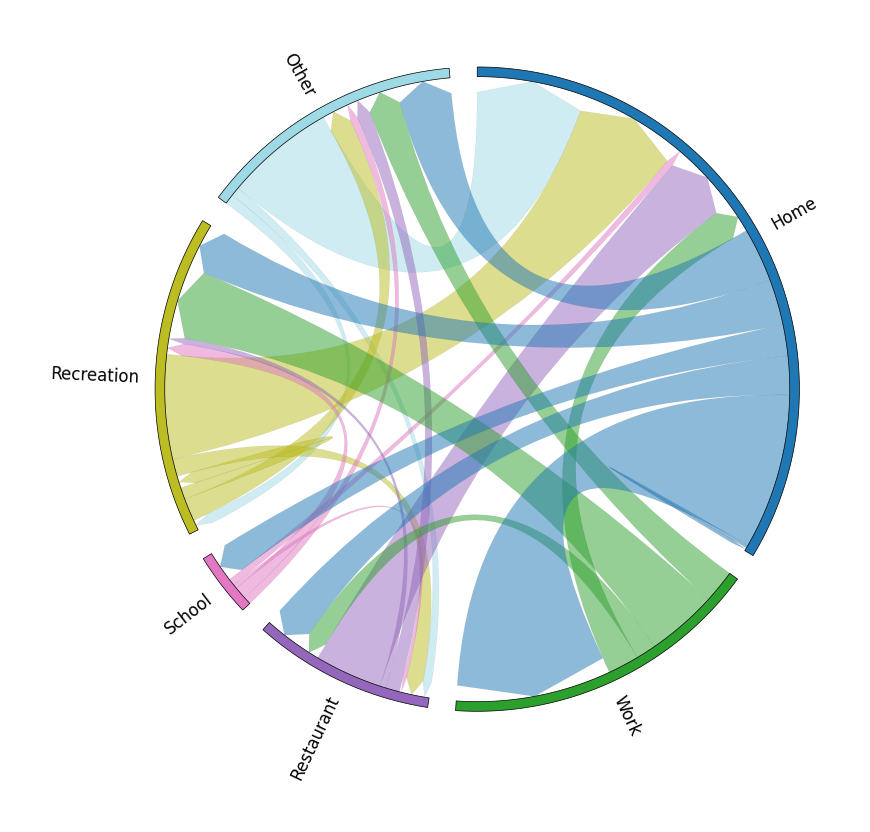

In [30]:
_, m_orig_sf = get_chord_diagram(data_t_sf, loc_type_key='loc_type', file_name='example.png', new_mappings=False, sim_mappings=True)
_, m_sf_gemini = get_chord_diagram(t_sf_gemini, loc_type_key='loc_type_new', file_name='example.png', new_mappings=False, sim_mappings=True)
_, m_sf_llama = get_chord_diagram(t_sf_llama, loc_type_key='loc_type_new', file_name='example.png', new_mappings=False, sim_mappings=True)
_, m_sf_gpt4 = get_chord_diagram(t_sf_gpt4, loc_type_key='loc_type_new', file_name='example.png', new_mappings=False, sim_mappings=True)
_, m_sf_llama_trained_large_exclude_infer_cities_3 = get_chord_diagram(t_sf_llama_trained_large_exclude_infer_cities_3, loc_type_key='loc_type_new', file_name='example.png', new_mappings=False, sim_mappings=True)
_, m_sf_llama_trained_large_3 = get_chord_diagram(t_sf_llama_trained_large_3, loc_type_key='loc_type_new', file_name='example.png', new_mappings=False, sim_mappings=True)
_, m_sf_sim = get_chord_diagram(t_sf_sim, loc_type_key='loc_type', file_name='example.png', new_mappings=False, sim_mappings=True)

In [31]:
def get_transient_prob_1(t, loc_type_key):
    dic = {}
    for each in t[loc_type_key]:
        for i in range(len(each)-1):
            k = each[i:i+2]
            if str(k) in dic.keys():
                dic[str(k)] += 1
            else:
                dic[str(k)] = 1
    main_lis = []
    for i in range(1, 7):
        sub_lis = []
        for j in range(1, 7):
            if str([i, j]) in dic.keys():
                sub_lis.append(dic[str([i, j])])
            else:
                sub_lis.append(0)
        main_lis.append(sub_lis)
    main_lis

    cols = [
        "Home",
        "Work",
        "Community",
        "In Transit",
        "Education",
        "Care",
    ]

    df = pd.DataFrame(main_lis, columns=cols, index=cols)
    df
    return df

In [32]:
t_orig_prob_1_sf = get_transient_prob_1_sim(data_t_sf, 'loc_type')

t_prob_1_sf_gemini = get_transient_prob_1_sim(t_sf_gemini, 'loc_type_new')

t_prob_1_sf_llama = get_transient_prob_1_sim(t_sf_llama, 'loc_type_new')

t_prob_1_sf_gpt4 = get_transient_prob_1_sim(t_sf_gpt4, 'loc_type_new')

t_prob_1_sf_llama_trained_large_exclude_infer_cities_3 = get_transient_prob_1_sim(t_sf_llama_trained_large_exclude_infer_cities_3, 'loc_type_new')
t_prob_1_sf_llama_trained_large_3 = get_transient_prob_1_sim(t_sf_llama_trained_large_3, 'loc_type_new')

t_prob_1_sf_sim = get_transient_prob_1_sim(t_sf_sim, 'loc_type')

In [33]:
t_orig_prob_2_sf = get_transient_prob_2_sim(data_t_sf, 'loc_type')

t_prob_2_sf_gemini = get_transient_prob_2_sim(t_sf_gemini, 'loc_type_new')

t_prob_2_sf_llama = get_transient_prob_2_sim(t_sf_llama, 'loc_type_new')

t_prob_2_sf_gpt4 = get_transient_prob_2_sim(t_sf_gpt4, 'loc_type_new')

t_prob_2_sf_llama_trained_large_exclude_infer_cities_3 = get_transient_prob_2_sim(t_sf_llama_trained_large_exclude_infer_cities_3, 'loc_type_new')
t_prob_2_sf_llama_trained_large_3 = get_transient_prob_2_sim(t_sf_llama_trained_large_3, 'loc_type_new')

t_prob_2_sf_sim = get_transient_prob_2_sim(t_sf_sim, 'loc_type')

In [34]:
order = 1
print(order)
models = ['gemini', 'llama', 'gpt4', 'llama_trained_large_3', 'sim']
for model in models:
    print( model,
        round(
            get_normalized_norm(
                eval(f't_orig_prob_{order}_sf'),
                eval(f't_prob_{order}_sf_{model}')
            ),
            5
        )
    )

order = 2
print(order)
models = ['gemini', 'llama', 'gpt4', 'llama_trained_large_3', 'sim']
for model in models:
    print( model,
        round(
            get_normalized_norm(
                eval(f't_orig_prob_{order}_sf'),
                eval(f't_prob_{order}_sf_{model}')
            ),
            5
        )
    )

1
gemini 0.03864
llama 0.12679
gpt4 0.18197
llama_trained_large_3 0.03733
sim 0.21472
2
gemini 0.03927
llama 0.09954
gpt4 0.15868
llama_trained_large_3 0.03399
sim 0.19391


In [35]:
order = 1
print(order)
models = ['llama_trained_large_exclude_infer_cities_3', 'sim']
for model in models:
    print( model,
        round(
            get_normalized_norm(
                eval(f't_orig_prob_{order}_sf'),
                eval(f't_prob_{order}_sf_{model}')
            ),
            5
        )
    )

order = 2
print(order)
for model in models:
    print( model,
        round(
            get_normalized_norm(
                eval(f't_orig_prob_{order}_sf'),
                eval(f't_prob_{order}_sf_{model}')
            ),
            5
        )
    )

1
llama_trained_large_exclude_infer_cities_3 0.03633
sim 0.21472
2
llama_trained_large_exclude_infer_cities_3 0.04004
sim 0.19391


In [36]:
order = 1
print(order)
models = ['gemini', 'llama', 'gpt4', 'sim']
for model in models:
    print( model,
        round(
            distance.jensenshannon(
                eval(f't_orig_prob_{order}_sf'),
                eval(f't_prob_{order}_sf_{model}')
            )[0],
            5
        )
    )

order = 2
print(order)
models = ['gemini', 'llama', 'gpt4', 'sim']
for model in models:
    print( model,
        round(
            distance.jensenshannon(
                eval(f't_orig_prob_{order}_sf'),
                eval(f't_prob_{order}_sf_{model}')
            )[0],
            5
        )
    )

1
gemini 0.08023
llama 0.14555
gpt4 0.28596
sim 0.1998
2
gemini 0.11419
llama 0.2248
gpt4 0.42016
sim 0.39842


In [37]:
res_1 = get_transient_destination_probabilities(order=1)
res_1

,SF_orig,Gemini,Llama,GPT-4,Simulated
Home,0.338983,0.318895,0.315672,0.226176,0.363976
Work,0.118188,0.106634,0.218964,0.081648,0.174988
Restaurant,0.081607,0.089797,0.084362,0.192298,0.100560
School,0.021743,0.017269,0.038237,0.012917,0.034998
Recreation,0.109513,0.102749,0.066358,0.171825,0.176855
Other,0.329966,0.364657,0.276406,0.315135,0.148623


In [38]:
def create_plots_for_destination_prob(res):
    res.transpose().plot.bar(
        stacked=True,
        title='Destination Probabilities',
        cmap='tab20'
    )
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    res.plot.bar(
        title='Destination Probabilities',
        figsize=(14, 5),
        cmap='tab20'
    )
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    pd.concat(
        [
            res[['Gemini']].sub(res['SF_orig'], axis=0),
            res[['Llama']].sub(res['SF_orig'], axis=0),
            res[['GPT-4']].sub(res['SF_orig'], axis=0),
            res[['Simulated']].sub(res['SF_orig'], axis=0),
        ],
        axis=1
    ).plot.bar(
        title='Difference in Destination Probabilities (Generated - Origial)',
        figsize=(14, 5),
        cmap='tab20'
    )
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


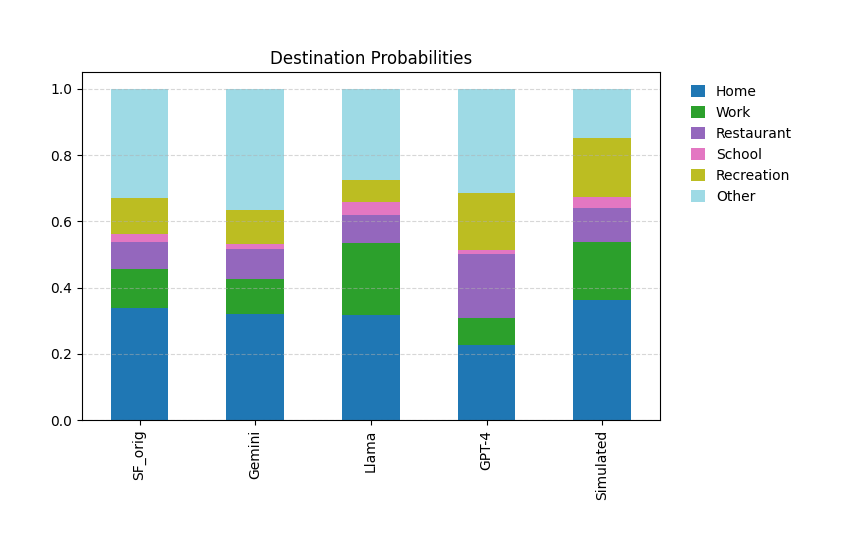

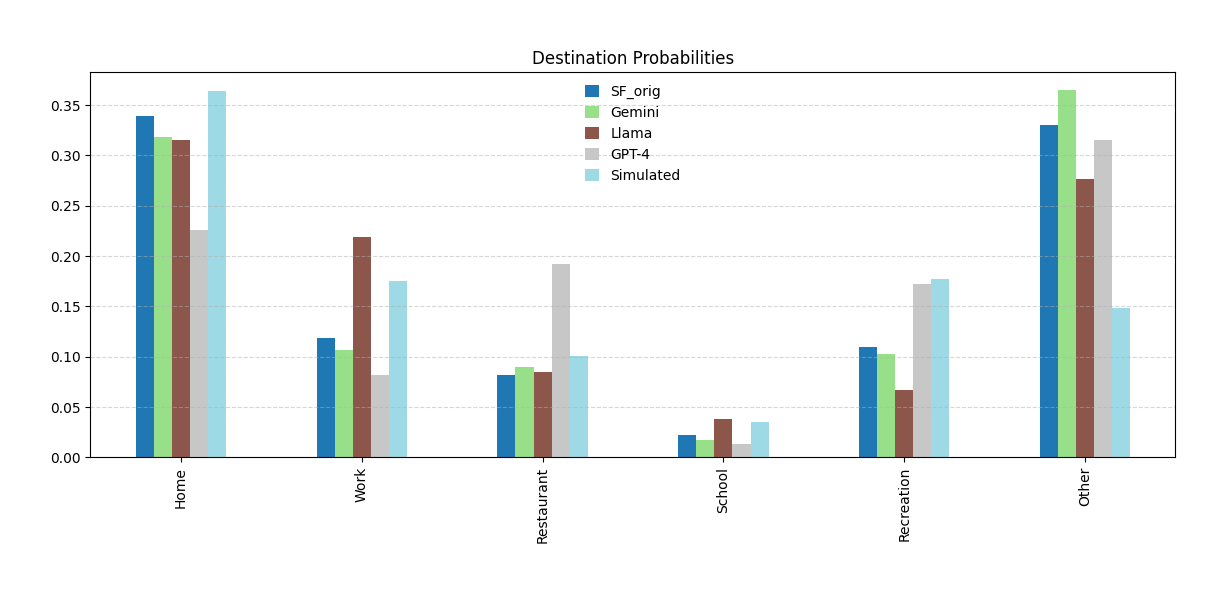

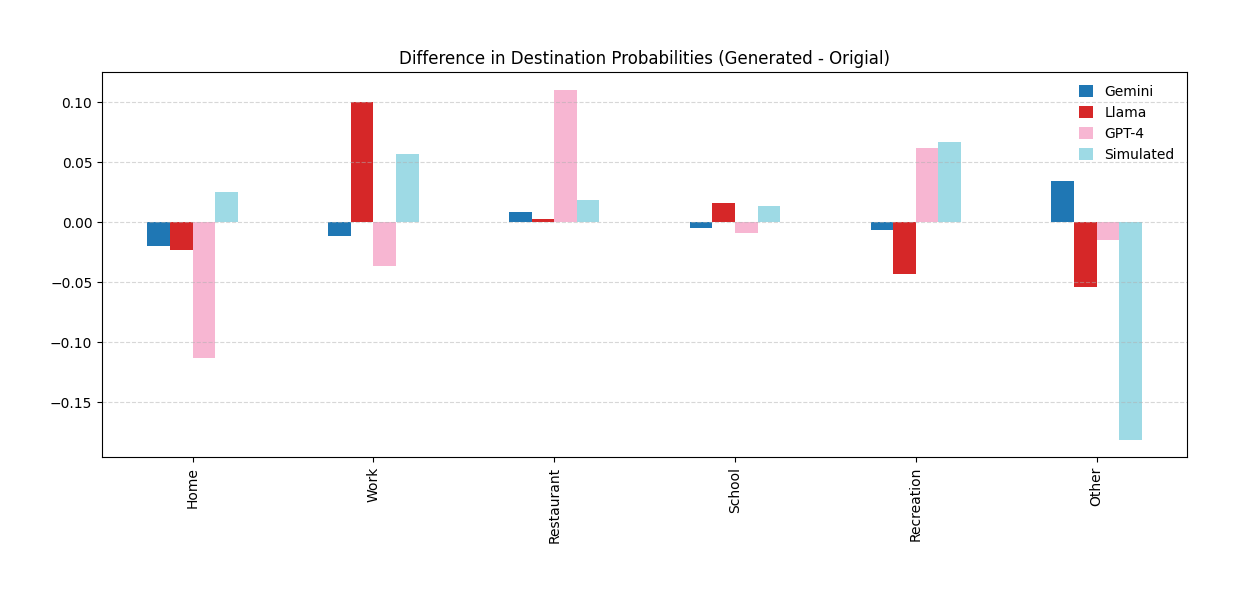

In [39]:
create_plots_for_destination_prob(res_1)

In [40]:
res_2 = get_transient_destination_probabilities(order=2)
res_2

,SF_orig,Gemini,Llama,GPT-4,Simulated
Home,0.425637,0.377101,0.370992,0.271449,0.514828
Work,0.079738,0.061800,0.150273,0.091362,0.007331
Restaurant,0.084745,0.097689,0.095529,0.112152,0.107298
School,0.006921,0.008578,0.031407,0.011420,0.000000
Recreation,0.091960,0.106268,0.073937,0.179795,0.207931
Other,0.311000,0.348564,0.277863,0.333821,0.162612


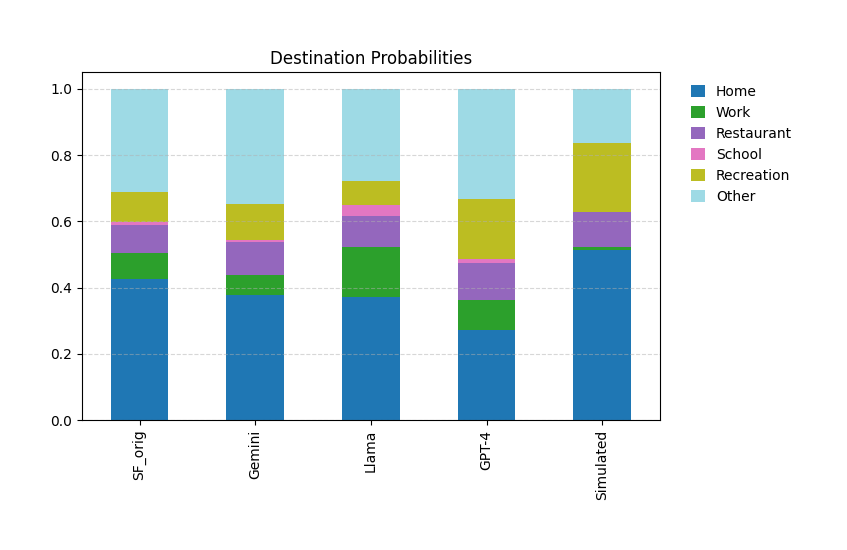

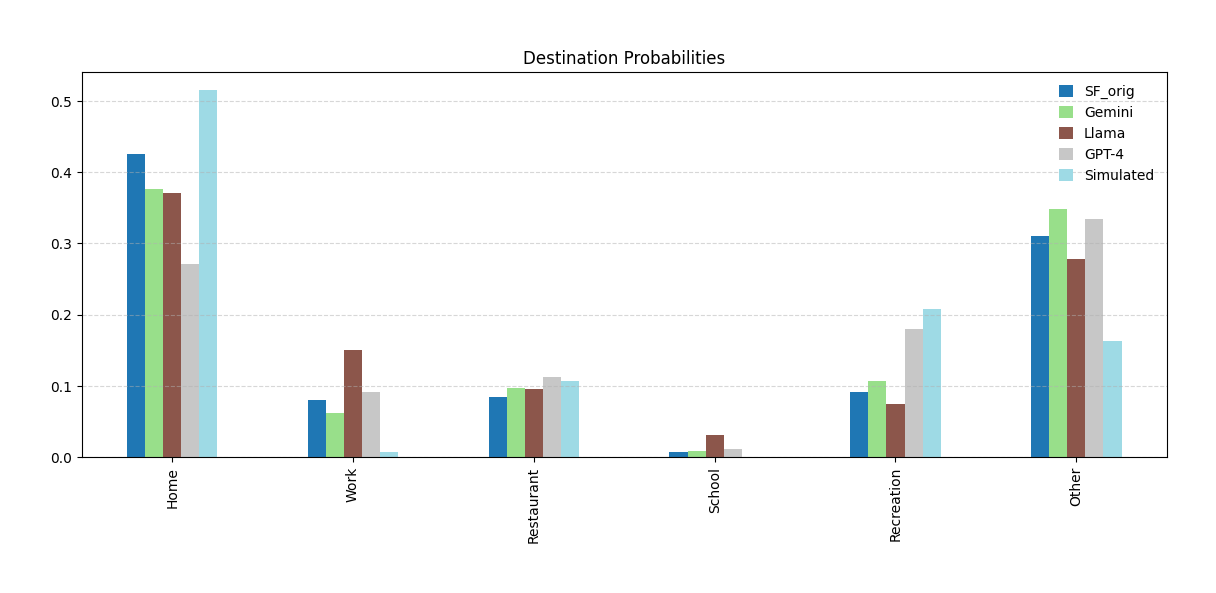

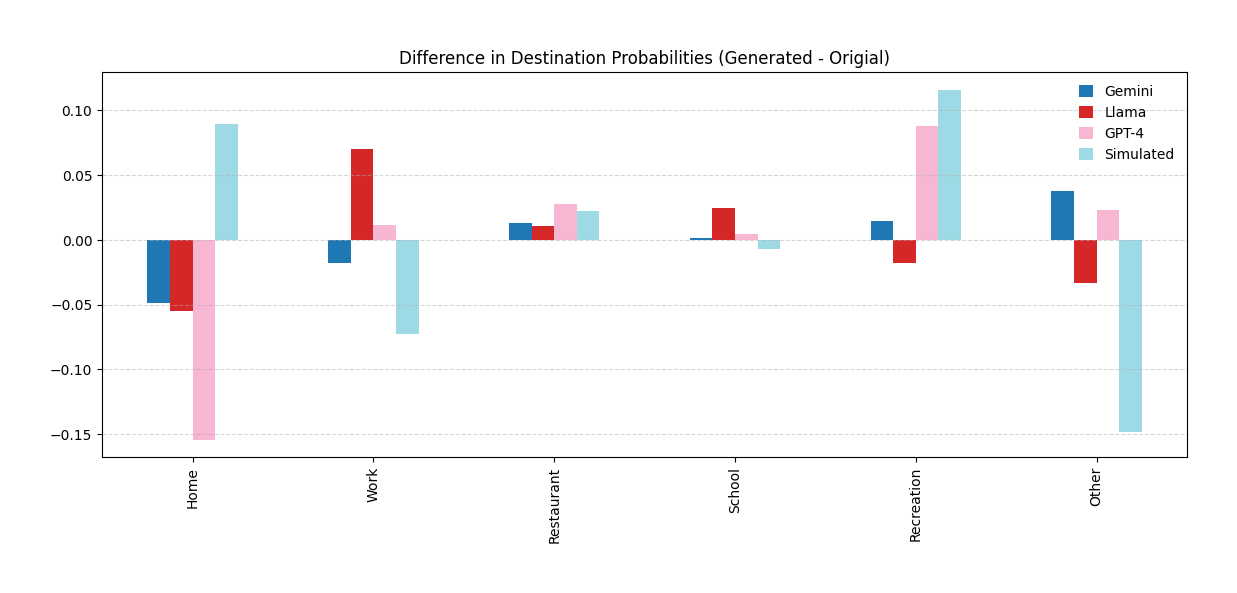

In [41]:
create_plots_for_destination_prob(res_2)

## Activity Chains

In [42]:
def sf_activity_chains_analysis(t_all_orig, t_sf_orig, t_sf_gen, name='LLama', gen_key='loc_type_new'):
    print(name)
    t_all_orig = t_all_orig['loc_type'].apply(tuple).value_counts()
    t_sf_orig = t_sf_orig['loc_type'].apply(tuple).value_counts()
    t_sf_gen = t_sf_gen[gen_key].apply(tuple).value_counts()
    t_all_orig = t_all_orig / t_all_orig.sum() * 100
    t_sf_orig = t_sf_orig / t_sf_orig.sum() * 100
    t_sf_gen = t_sf_gen / t_sf_gen.sum() * 100
    
    
    val_1 = len(t_sf_gen.index.intersection(t_sf_orig.index)) / len(t_sf_gen.index)
        
    print(f"% of Generated Chains Present in Actual Chains: {round(val_1 * 100, 2)}")
    
    overlap_1 = 0
    for value in t_sf_gen.index.intersection(t_sf_orig.index):
        overlap_1 += t_sf_gen[value]
    
    print(f"Weight of Generated Chains Present in Actual Chains: {round(overlap_1, 2)}")
    
    val_2 = len(t_sf_gen.index.intersection(t_all_orig.index)) / len(t_sf_gen.index)
        
    print(f"% of Generated Chains Present in All Actual Chains: {round(val_2 * 100, 2)}")
    
    
    overlap_2 = 0
    for value in t_sf_gen.index.intersection(t_all_orig.index):
        overlap_2 += t_sf_gen[value]
    
    print(f"Weight of Generated Chains Present in All Actual Chains: {round(overlap_2, 2)}")
    
    val_3 = len(t_sf_gen.index.intersection(t_sf_orig.index)) / len(t_sf_orig.index)
        
    print(f"% of Actual Chains Present in Generated Chains: {round(val_3 * 100, 2)}")
    
    overlap_3 = 0
    for value in t_sf_gen.index.intersection(t_sf_orig.index):
        overlap_3 += t_sf_orig[value]
    
    print(f"Weight of Actual Chains Present in Generated Chains: {round(overlap_3, 2)}")
    
    overlap = 0
    for value in t_sf_gen.index.intersection(t_sf_orig.index):
        overlap += min(t_sf_gen[value], t_sf_orig[value])
    
    print(f"Weight Overlap of Actual Chains and Generated Chains: {round(overlap, 2)}")

    return val_1, overlap_1, val_2, overlap_2, val_3, overlap_3, overlap
    

In [43]:
val_1_llama, overlap_1_llama, val_2_llama, overlap_2_llama, val_3_llama, overlap_3_llama, overlap_llama = sf_activity_chains_analysis(data_t_all, data_t_sf, t_sf_llama, name='llama')
val_1_llama_trained, overlap_1_llama_trained, val_2_llama_trained, overlap_2_llama_trained, val_3_llama_trained, overlap_3_llama_trained, overlap_llama_trained = sf_activity_chains_analysis(data_t_all, data_t_sf, t_sf_llama_trained_large_3, name='llama_trained')
val_1_sim, overlap_1_sim, val_2_sim, overlap_2_sim, val_3_sim, overlap_3_sim, overlap_sim = sf_activity_chains_analysis(data_t_all, data_t_sf, t_sf_sim, name='Patterns of Life', gen_key='loc_type')

llama
% of Generated Chains Present in Actual Chains: 23.54
Weight of Generated Chains Present in Actual Chains: 47.38
% of Generated Chains Present in All Actual Chains: 57.14
Weight of Generated Chains Present in All Actual Chains: 69.43
% of Actual Chains Present in Generated Chains: 12.25
Weight of Actual Chains Present in Generated Chains: 55.05
Weight Overlap of Actual Chains and Generated Chains: 32.39
llama_trained
% of Generated Chains Present in Actual Chains: 43.35
Weight of Generated Chains Present in Actual Chains: 74.1
% of Generated Chains Present in All Actual Chains: 75.99
Weight of Generated Chains Present in All Actual Chains: 87.95
% of Actual Chains Present in Generated Chains: 17.78
Weight of Actual Chains Present in Generated Chains: 61.09
Weight Overlap of Actual Chains and Generated Chains: 53.35
Patterns of Life
% of Generated Chains Present in Actual Chains: 45.79
Weight of Generated Chains Present in Actual Chains: 86.69
% of Generated Chains Present in All 

In [77]:
val_1_llama_trained, overlap_1_llama_trained, val_2_llama_trained, overlap_2_llama_trained, val_3_llama_trained, overlap_3_llama_trained, overlap_llama_trained = sf_activity_chains_analysis(data_t_all, data_t_sf, t_sf_llama_trained_large_exclude_infer_cities_3, name='llama_trained')
val_1_sim, overlap_1_sim, val_2_sim, overlap_2_sim, val_3_sim, overlap_3_sim, overlap_sim = sf_activity_chains_analysis(data_t_all, data_t_sf, t_sf_sim, name='Patterns of Life', gen_key='loc_type')

llama_trained
% of Generated Chains Present in Actual Chains: 43.8
Weight of Generated Chains Present in Actual Chains: 75.96
% of Generated Chains Present in All Actual Chains: 81.78
Weight of Generated Chains Present in All Actual Chains: 90.59
% of Actual Chains Present in Generated Chains: 16.01
Weight of Actual Chains Present in Generated Chains: 59.35
Weight Overlap of Actual Chains and Generated Chains: 52.65
Patterns of Life
% of Generated Chains Present in Actual Chains: 48.15
Weight of Generated Chains Present in Actual Chains: 86.9
% of Generated Chains Present in All Actual Chains: 86.11
Weight of Generated Chains Present in All Actual Chains: 97.91
% of Actual Chains Present in Generated Chains: 3.68
Weight of Actual Chains Present in Generated Chains: 28.61
Weight Overlap of Actual Chains and Generated Chains: 27.92


In [47]:
t_sf_sim['loc_type_new'] = t_sf_sim['loc_type']

In [53]:
def get_count_rep(x):
    if x == 1:
        return '1'
    elif x < 10:
        return '< 10'
    # elif x < 50:
    #     return '< 50'
    # elif x < 100:
    #     return '< 100'

def get_chains_df(a, others, city='SF'):
    # a = a.sample(1500)
    plt.figure(figsize=(8,4))
    a = a['loc_type'].apply(tuple).value_counts().sort_values(ascending=False)
    a_2 = a.copy()
    a = a / a.sum() * 100
    a = a.reset_index()
    a_2 = a_2.reset_index()
    a_2.rename(columns={'count': 'count_num'}, inplace=True)
    a['cumsum_orig'] = a['count'].cumsum()
    a_3  = pd.merge(a.assign(loc_type=a.loc_type.astype(str)), a_2.assign(loc_type=a_2.loc_type.astype(str)), on='loc_type', how='left')
    a_3['count_rep'] = a_3['count_num'].apply(lambda x: get_count_rep(x))
    a = a_3
    for i, (k, b) in enumerate(others.items()):
        key = 'loc_type_new'
        if '-orig' in k:
            key = 'loc_type'
        b = b[key].apply(tuple).value_counts().sort_values(ascending=False)
        b = b / b.sum() * 100
        b = b.reset_index()
        b.rename(columns={key: 'loc_type','count': f'count_{k}'}, inplace=True)
        if i == 0:
            final_df = pd.merge(a.assign(loc_type=a.loc_type.astype(str)), b.assign(loc_type=b.loc_type.astype(str)), on='loc_type', how='left')
        else:
            final_df = pd.merge(final_df.assign(loc_type=final_df.loc_type.astype(str)), b.assign(loc_type=b.loc_type.astype(str)), on='loc_type', how='left')
        final_df[f'cumsum_{k}'] = final_df[f'count_{k}'].cumsum()

    first_occurrences = {}
    for rep_value in final_df['count_rep'].unique():
        if rep_value == None:
            continue
        first_occurrences[rep_value] = final_df.index[final_df['count_rep'] == rep_value][0]
    
    for k, idx in first_occurrences.items():
        if k == '1':
            plt.axvline(x=idx, color=one_color_line, linestyle='dotted', label=f'First {k} count occurrence')
        elif k == '< 10':
            plt.axvline(x=idx, color=ten_color_line, linestyle='--', label=f'First {k} count occurrence')
        # plt.text(idx, f['cumsum_orig'].iloc[idx], k, color='red', fontsize=10, ha='right')



    cum_sum_cols = [each for each in final_df.columns.to_list() if 'cumsum' in each]
    # final_df.rename(columns={'cumsum_orig': 'cumsum_Actual'}, inplace=True)
    for i in cum_sum_cols:
        if i == 'cumsum_orig':
            plt.scatter(final_df.index, final_df[i], label='Actual')
        elif i == 'cumsum_LA-orig':
            plt.scatter(final_df.index, final_df[i], label='LA Actual')
        else:
            plt.scatter(final_df.index, final_df[i], label=i.split('_')[-1])
    plt.tight_layout()
    plt.legend(loc='lower right', fontsize='x-large', markerscale=2)
    # plt.legend(loc='lower left', ncol=3)
    # plt.title(f'{city} Cumulative sum of chains')
    plt.show()
    return final_df


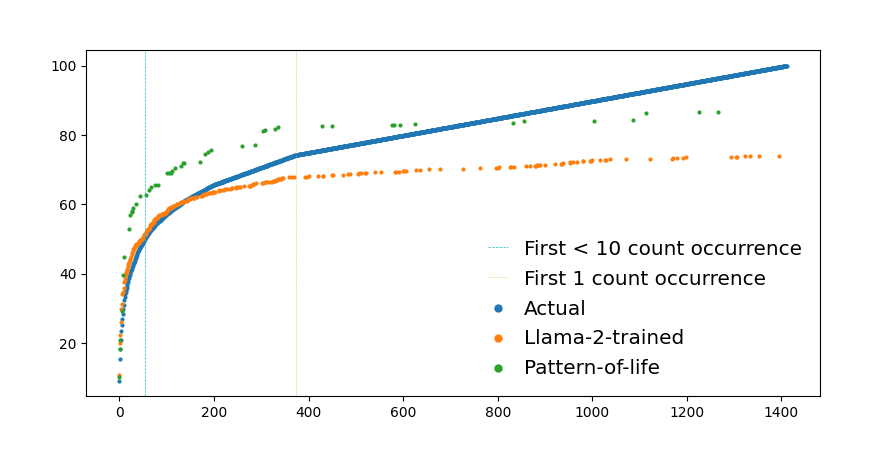

In [54]:
others = {
    'Llama-2-trained': t_sf_llama_trained_large_3,
    'Pattern-of-life': t_sf_sim,
}

count_columns_names = ['count']
for k,v in others.items():
    count_columns_names.append(f'count_{k}')

chains_sf_partial = get_chains_df(
    data_t_sf,
    others,
    city='SF'
)

In [136]:
print(chains_sf[['count', 'count_gemini', 'count_llama', 'count_gpt4', 'count_sim']].corr()['count'])
print(chains_sf[['count', 'count_gemini', 'count_llama', 'count_gpt4', 'count_sim']].corr(method='spearman')['count'])

count           1.000000
count_gemini    0.606584
count_llama     0.834038
count_gpt4     -0.116527
count_sim       0.712252
Name: count, dtype: float64
count           1.000000
count_gemini    0.359143
count_llama     0.429825
count_gpt4     -0.058908
count_sim       0.651258
Name: count, dtype: float64


In [36]:
def create_activity_chain_plots(df, start_index=0, end_index=100, city='SF'):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(18, 16))
    bar1 = ax0.bar(df[start_index:end_index].index, df[start_index:end_index]['count'], label='Original', color=actual_color)
    bar2 = ax0.bar(df[start_index:end_index].index, df[start_index:end_index]['count_gemini'], label='Gemini', alpha=0.7, color=gemini_color)
    ax0.legend(loc='upper right')
    ax0.set_xlim(left=-1)

    for i, rect1 in enumerate(bar1):
        height1 = rect1.get_height()
        height2 = bar2[i].get_height()
        if np.isnan(height2):
            height2 = 0
        height = height1 if height1 > height2 else height2

        ax0.text(rect1.get_x() + rect1.get_width() / 2.0, height, f'{df.iloc[i].loc_type}', ha='center', va='bottom', rotation=90, fontsize='small')

    bar1 = ax1.bar(df[start_index:end_index].index, df[start_index:end_index]['count'], label='Original', color=actual_color)
    bar2 = ax1.bar(df[start_index:end_index].index, df[start_index:end_index]['count_llama'], label='Llama', alpha=0.7, color=llama_color)
    ax1.legend(loc='upper right')
    ax1.set_xlim(left=-1)

    for i, rect1 in enumerate(bar1):
        height1 = rect1.get_height()
        height2 = bar2[i].get_height()
        if np.isnan(height2):
            height2 = 0
        height = height1 if height1 > height2 else height2

        ax1.text(rect1.get_x() + rect1.get_width() / 2.0, height, f'{df.iloc[i].loc_type}', ha='center', va='bottom', rotation=90, fontsize='small')

    bar1 = ax2.bar(df[start_index:end_index].index, df[start_index:end_index]['count'], label='Original', color=actual_color)
    bar2 = ax2.bar(df[start_index:end_index].index, df[start_index:end_index]['count_gpt4'], label='GPT4', alpha=0.7, color=gpt4_color)
    ax2.legend(loc='upper right')
    ax2.set_xlim(left=-1)

    for i, rect1 in enumerate(bar1):
        height1 = rect1.get_height()
        height2 = bar2[i].get_height()
        if np.isnan(height2):
            height2 = 0
        height = height1 if height1 > height2 else height2

        ax2.text(rect1.get_x() + rect1.get_width() / 2.0, height, f'{df.iloc[i].loc_type}', ha='center', va='bottom', rotation=90, fontsize='small')

    bar1 = ax3.bar(df[start_index:end_index].index, df[start_index:end_index]['count'], label='Original', color=actual_color)
    bar2 = ax3.bar(df[start_index:end_index].index, df[start_index:end_index]['count_sim'], label='Simulated', alpha=0.7, color=sim_color)
    ax3.legend(loc='upper right')
    ax3.set_xlim(left=-1)

    for i, rect1 in enumerate(bar1):
        height1 = rect1.get_height()
        height2 = bar2[i].get_height()
        if np.isnan(height2):
            height2 = 0
        height = height1 if height1 > height2 else height2

        ax3.text(rect1.get_x() + rect1.get_width() / 2.0, height, f'{df.iloc[i].loc_type}', ha='center', va='bottom', rotation=90, fontsize='small')


    plt.show()

    ax = df[start_index:end_index][['count', 'count_gemini', 'count_llama', 'count_gpt4']].plot.bar(figsize=(18, 5), color=[actual_color, gemini_color, llama_color, gpt4_color])
    ax.set_xticklabels(df[start_index:end_index].loc_type.to_list(), rotation=90)
    plt.show()

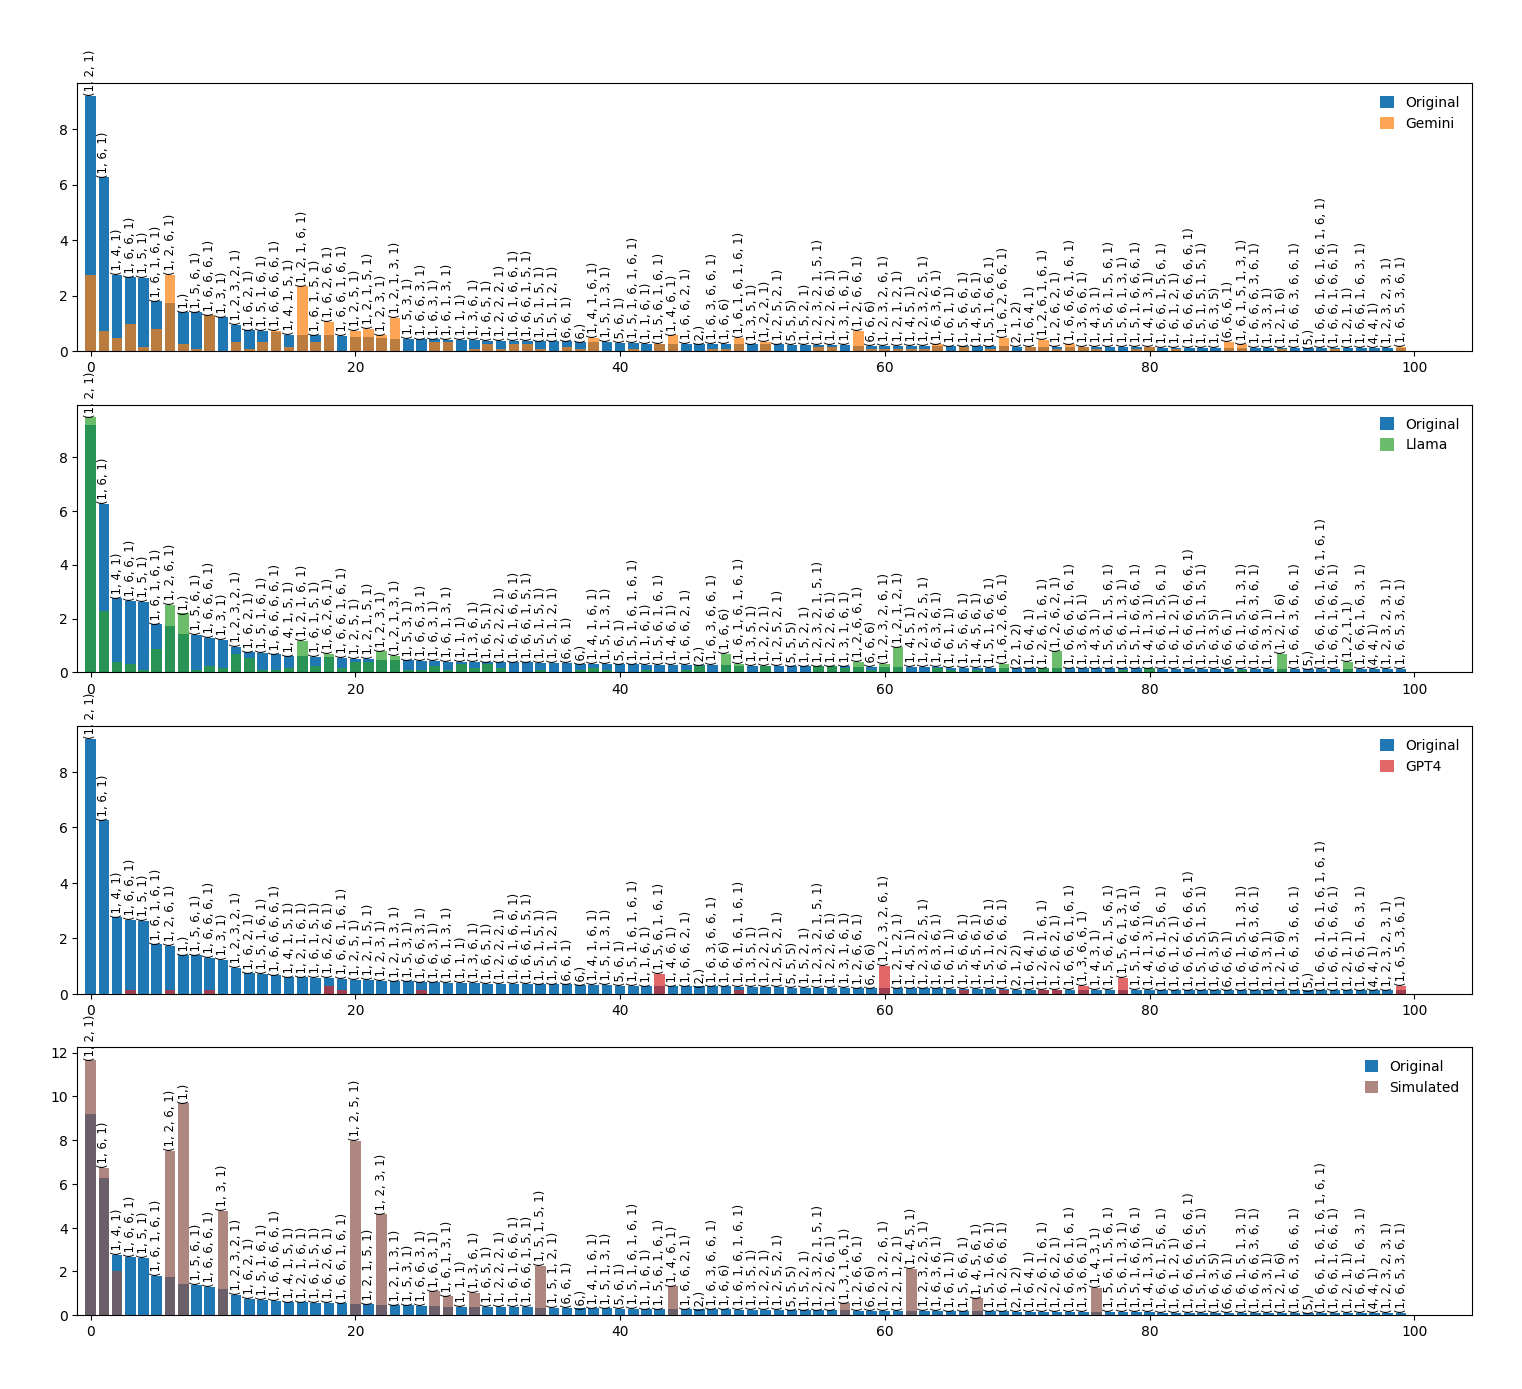

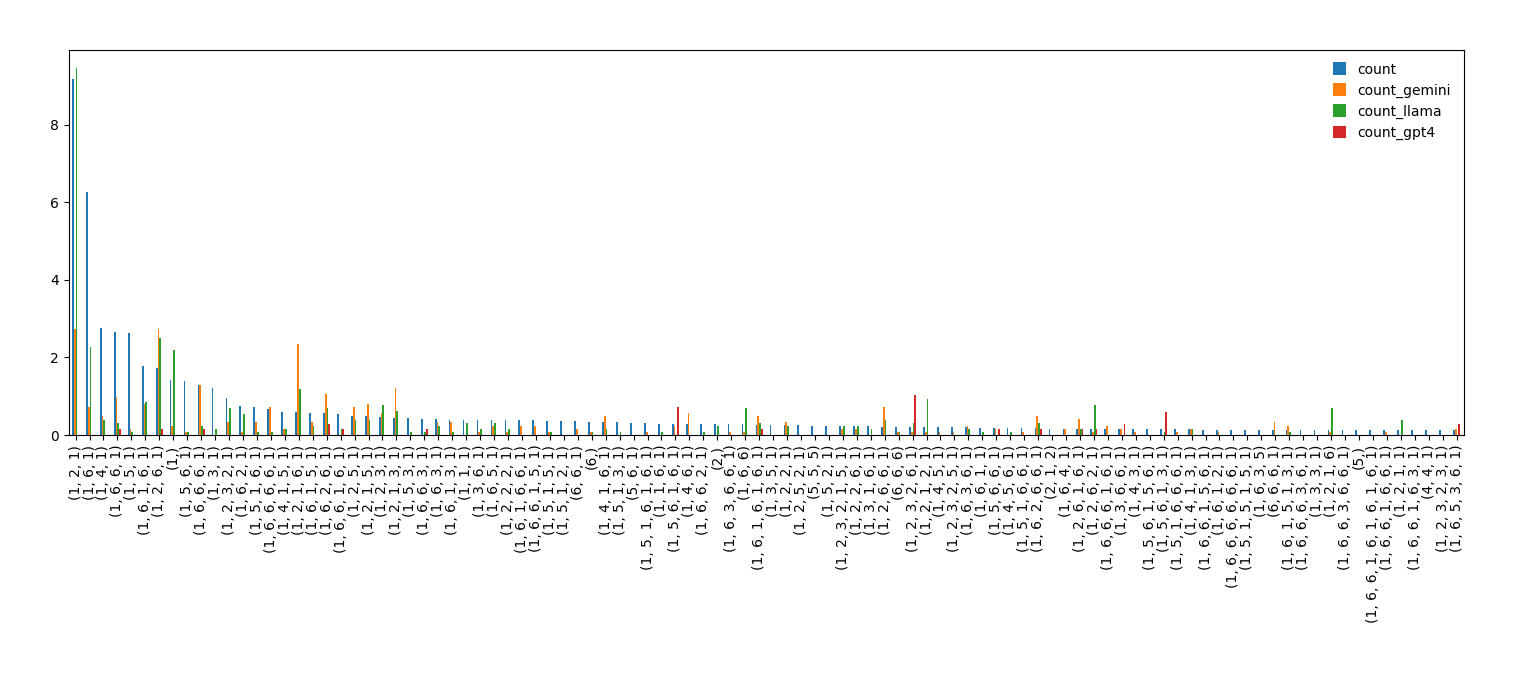

In [37]:
create_activity_chain_plots(chains_sf, city='SF')